In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import csv
import os
import re

from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

In [2]:
FOLDER = "logs"
files = os.listdir(FOLDER)
len(files)

321

In [3]:
def label_replace(attn_name, update_rule):
    model_name = attn_name + "_" + update_rule
    if model_name == "tanh_fwm":
        return "Schlag (2021)"
    
    elif model_name == "dpfp1_fwm":
        return "Schlag (2021) with DPFP-1"
    
    elif model_name == "dpfp1_ours":
        return "DPFP-1 update"
    
    elif model_name == "dpfp2_ours":
        return "DPFP-2 update"
    
    elif model_name == "dpfp3_ours":
        return "DPFP-3 update"
    
    elif model_name == "dpfp1_sum":
        return "DPFP-1 sum"
    
    elif model_name == "dpfp2_sum":
        return "DPFP-2 sum"
    
    elif model_name == "favor128_ours":
        return "FAVOR-128 update"
    
    elif model_name == "favor64_ours":
        return "FAVOR-64 update"
    
    elif model_name == "linear_ours":
        return "Linear update"
    else:
        return model_name

In [4]:
df = pd.DataFrame(
    columns=["dataloader","attn_name","hidden_size","seq_len",
             "n_keys","with_replace","csvfile", "steps", "loss", "label"])

# filename example: d64_dpfp1_sum_AssocSeq80N40R1.csv
pattern = re.compile("d(\d+)\_(.+)_(.+)_AssocSeq(\d+)N(\d+)R(\d+)")

for idx, f in enumerate(files):
    m = pattern.match(f)
    csv_df = pd.read_csv(os.path.join(FOLDER, f))
    df = df.append({
        "dataloader": "AssocSeq",
        "attn_name": m.group(2),
        "update_rule": m.group(3),
        "hidden_size": int(m.group(1)),
        "seq_len": int(m.group(4)),
        "n_keys": int(m.group(5)),
        "with_replace": int(m.group(6)),
        "csvfile": f,
        "steps": int(csv_df.iloc[-1].step),
        "loss": csv_df.iloc[-1]["eval-loss"],
        "label": f"{label_replace(m.group(2), m.group(3))}"
    }, ignore_index=True)

## Plot loss over number of keys

In [5]:
dfq = df.copy()
dfq = dfq[dfq.with_replace == 1]
dfq = dfq[dfq.attn_name != "favor64"] # NaNs
dfq = dfq[dfq.attn_name != "favor128"] # NaNs

set(dfq.label)

{'DPFP-1 sum',
 'DPFP-1 update',
 'DPFP-2 sum',
 'DPFP-2 update',
 'Linear update',
 'Schlag (2021)',
 'Schlag (2021) with DPFP-1'}

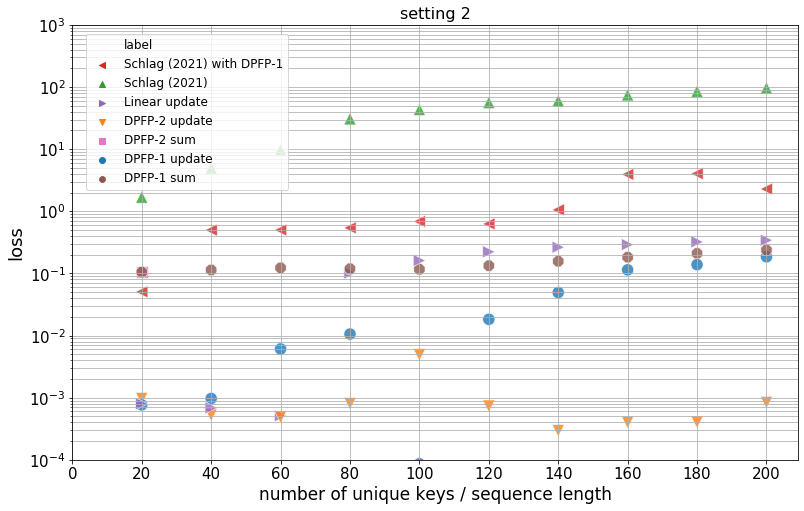

In [6]:
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')

fig, ax = plt.subplots(figsize=(13,8))
scat = sns.scatterplot(x="n_keys",
                       y="loss", 
                       style="label",
                       hue="label",
                       data=dfq,
                       s=150,
                       alpha=0.8,
                       markers=filled_markers)
scat.axes.set_title("setting 2", fontsize=16)
scat.axes.set_xlabel("number of unique keys / sequence length", fontsize=17)
scat.axes.set_ylabel("loss", fontsize=18)
scat.axes.set_yscale('log', basey=10)
scat.axes.set(ylim=(0.0001, 1000.0))
scat.tick_params(labelsize=15)
plt.xticks(np.arange(0, 200, 40))

# sort both labels and handles by labels
handles, labels = scat.axes.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
scat.axes.legend(handles, labels, loc="center left", bbox_to_anchor=(0.01,0.80), prop={'size': 12})
#scat.axes.legend(handles, labels, loc="best", prop={'size': 12})

# major and minor ticks
scat.axes.xaxis.set_major_locator(MultipleLocator(20))
scat.axes.xaxis.set_major_formatter(FormatStrFormatter('%d'))
scat.axes.xaxis.set_minor_locator(MultipleLocator(20))

#scat.axes.yaxis.set_major_locator(MultipleLocator(0.5))
#scat.axes.yaxis.set_minor_locator(MultipleLocator(0.5))

# grid 
scat.axes.xaxis.grid(True, which='both')
scat.axes.yaxis.grid(True, which='both')

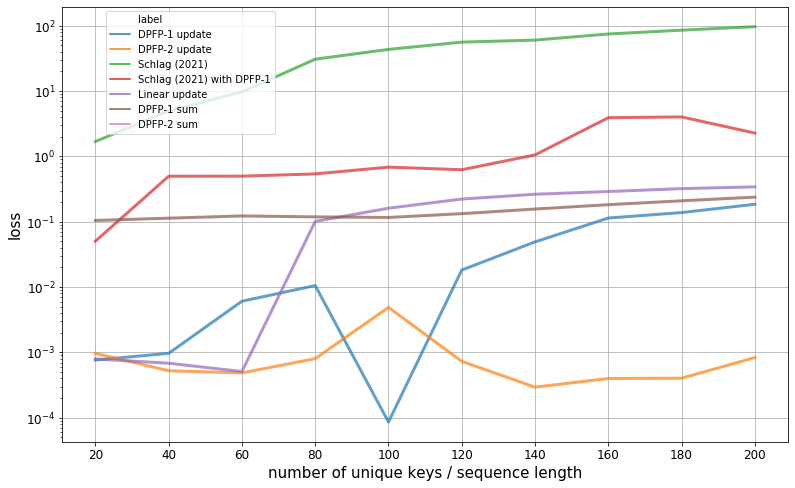

In [7]:
fig, ax = plt.subplots(figsize=(13,8))
line = sns.lineplot(x="n_keys",
                    y="loss",
                    hue="label",
                    data=dfq,
                    alpha=0.7,
                    linewidth=3)
#line.axes.set_title("setting 1", fontsize=20)
line.axes.set_xlabel("number of unique keys / sequence length", fontsize=15)
line.axes.set_ylabel("loss", fontsize=15)
line.axes.set_yscale('log', basey=10)
line.tick_params(labelsize=12)
line.axes.legend(loc="center right", bbox_to_anchor=(0.3,0.85))
plt.xticks(np.arange(20, 201, 20))
plt.grid()

## Plot loss curve for specific experiments

In [8]:
N_KEYS = 20

dfq = df.copy()
dfq = dfq[dfq.steps > 0]
dfq = dfq[dfq.n_keys == N_KEYS]
dfq = dfq[dfq.with_replace == 1]
dfq = dfq[dfq.attn_name != "dpfp2"]
dfq = dfq[dfq.attn_name != "favor64"] # NaNs
dfq = dfq[dfq.attn_name != "favor128"] # NaNs
dfq = dfq[dfq.attn_name != "linear"]

dfq

,dataloader,attn_name,hidden_size,seq_len,n_keys,with_replace,csvfile,steps,loss,label,update_rule
11,AssocSeq,tanh,64,40,20,1,d64_tanh_fwm_AssocSeq40N20R1.csv,15400,1.691824,Schlag (2021),fwm
127,AssocSeq,dpfp1,64,40,20,1,d64_dpfp1_fwm_AssocSeq40N20R1.csv,3900,0.050531,Schlag (2021) with DPFP-1,fwm
278,AssocSeq,dpfp1,64,40,20,1,d64_dpfp1_sum_AssocSeq40N20R1.csv,1300,0.104796,DPFP-1 sum,sum
286,AssocSeq,dpfp1,64,40,20,1,d64_dpfp1_ours_AssocSeq40N20R1.csv,700,0.000766,DPFP-1 update,ours


In [9]:
df_losses = pd.DataFrame(columns=["label", "loss", "step"])

for _, row in dfq.iterrows():
    df_csv = pd.read_csv(os.path.join(FOLDER, row.csvfile))
    for _, csv_row in df_csv.iterrows():
        df_losses = df_losses.append({
            "label": row.label,
            "loss": csv_row["eval-loss"],
            "step": csv_row.step
        }, ignore_index=True)

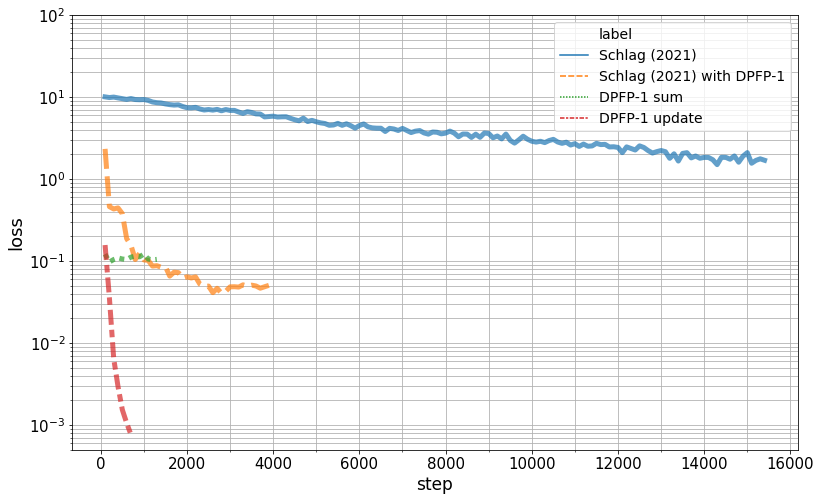

In [10]:
fig, ax = plt.subplots(figsize=(13,8))
line = sns.lineplot(x="step",
                    y="loss",
                    hue="label",
                    style="label",
                    data=df_losses,
                    alpha=0.7,
                    linewidth=5)
#line.axes.set_title(f"Setting 1 with {N_KEYS} unique keys", fontsize=20)
line.axes.set_xlabel("step", fontsize=17)
line.axes.set_ylabel("loss", fontsize=18)
line.axes.set(ylim=(0.0005, 100))
line.axes.set_yscale('log', basey=10)
line.axes.legend(prop={'size': 14})
line.tick_params(labelsize=15)

# major and minor ticks
line.axes.xaxis.set_major_locator(MultipleLocator(2000))
line.axes.xaxis.set_major_formatter(FormatStrFormatter('%d'))
line.axes.xaxis.set_minor_locator(MultipleLocator(1000))

# grid 
line.axes.xaxis.grid(True, which='both')
line.axes.yaxis.grid(True, which='both')